In [1]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from pyproj import CRS, Transformer
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from gamma.utils import association, estimate_eps
from pyproj import Proj

In [2]:
#region = "california"
region = "chile2014"
#region = "ridgecrest_demo"
#region = "chile"
data_path = lambda x: os.path.join(f"region/{region}", x)
result_path = f"results/{region}"
if not os.path.exists(result_path):
    os.makedirs(result_path)
result_path = lambda x: os.path.join(f"results/{region}", x)
station_csv = data_path("stations.csv")
picks_csv = data_path("picks.csv")
if not os.path.exists("figures"):
    os.makedirs("figures")
figure_dir = lambda x: os.path.join("figures", x)

In [3]:
## read picks
picks = pd.read_csv(picks_csv, parse_dates=["phase_time"])
picks.rename(columns={"station_id": "id", "phase_time": "timestamp", "phase_type": "type", "phase_score": "prob", "phase_amplitude": "amp"}, inplace=True)

## read stations
stations = pd.read_csv(station_csv)
stations.rename(columns={"station_id": "id"}, inplace=True)

## Automatic region; you can also specify a region
x0 = stations["longitude"].median()
y0 = stations["latitude"].median()
xmin = stations["longitude"].min()
xmax = stations["longitude"].max()
ymin = stations["latitude"].min()
ymax = stations["latitude"].max()
config = {}
config["center"] = (x0, y0)
config["xlim_degree"] = (2 * xmin - x0, 2 * xmax - x0)
config["ylim_degree"] = (2 * ymin - y0, 2 * ymax - y0)

## projection to km
proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z(km)"] = stations["elevation_m"].apply(lambda x: -x/1e3)

# set number of cpus
config["ncpu"] = 32

# Gamma
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = False
config["x(km)"] = proj(longitude=config["xlim_degree"], latitude=[config["center"][1]] * 2)[0]
config["y(km)"] = proj(longitude=[config["center"][0]] * 2, latitude=config["ylim_degree"])[1]
config["z(km)"] = (0, 250)
config["vel"] = {"p": 7.0, "s": 7.0 / 1.75}  # We assume rather high velocities as we expect deeper events
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # z
    (None, None),  # t
)
config["dbscan_eps"] = 25  # seconds
config["dbscan_min_samples"] = 3

# Filtering
config["min_picks_per_eq"] = 5
config["max_sigma11"] = 2.0
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

for k, v in config.items():
    print(f"{k}: {v}")

center: (-69.81963999999999, -21.18148)
xlim_degree: (-71.28852, -68.48716000000002)
ylim_degree: (-28.070459999999997, -15.48872)
ncpu: 32
dims: ['x(km)', 'y(km)', 'z(km)']
use_dbscan: True
use_amplitude: False
x(km): (-152.5398027404779, 138.37415375615748)
y(km): (-763.9956480592314, 630.6187640835277)
z(km): (0, 250)
vel: {'p': 7.0, 's': 4.0}
method: BGMM
oversample_factor: 4
bfgs_bounds: ((-153.5398027404779, 139.37415375615748), (-764.9956480592314, 631.6187640835277), (0, 251), (None, None))
dbscan_eps: 25
dbscan_min_samples: 3
min_picks_per_eq: 5
max_sigma11: 2.0
max_sigma22: 1.0
max_sigma12: 1.0


## association

In [4]:
event_idx0 = 0 ## current earthquake index
assignments = []
standard_catalog, assignments = association(picks, stations, config, event_idx0, config["method"])
event_idx0 += len(standard_catalog)

Associating 263 clusters with 8 CPUs


In [5]:
standard_catalog

[{'time': '2014-04-03T09:47:56.704',
  'magnitude': 999,
  'sigma_time': 1.0130100356962453,
  'sigma_amp': 0,
  'cov_time_amp': 0,
  'gamma_score': 38.81545107696544,
  'num_picks': 13,
  'num_p_picks': 9,
  'num_s_picks': 4,
  'event_index': 3,
  'x(km)': -145.48075625452194,
  'y(km)': 56.21633804817633,
  'z(km)': 0.0},
 {'time': '2014-04-03T09:48:11.190',
  'magnitude': 999,
  'sigma_time': 0.7569614258617678,
  'sigma_amp': 0,
  'cov_time_amp': 0,
  'gamma_score': 9.184548923034564,
  'num_picks': 11,
  'num_p_picks': 8,
  'num_s_picks': 3,
  'event_index': 4,
  'x(km)': -68.30477429485276,
  'y(km)': -41.40863307067844,
  'z(km)': 71.21621580566973},
 {'time': '2014-04-03T00:44:30.436',
  'magnitude': 999,
  'sigma_time': 0.7026092698115258,
  'sigma_amp': 0,
  'cov_time_amp': 0,
  'gamma_score': 22.374463941837796,
  'num_picks': 19,
  'num_p_picks': 13,
  'num_s_picks': 6,
  'event_index': 15,
  'x(km)': -91.16717018537256,
  'y(km)': 144.0476364180247,
  'z(km)': 5.3736034407

In [6]:
## create catalog
standard_catalog = pd.DataFrame(standard_catalog)
standard_catalog[["longitude","latitude"]] = standard_catalog.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
standard_catalog["depth_km"] = standard_catalog["z(km)"]
standard_catalog.to_csv(result_path("gamma_events.csv"), index=False, 
                float_format="%.3f",
                date_format='%Y-%m-%dT%H:%M:%S.%f')

## add assignment to picks
assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({'event_index': int})
picks.to_csv(result_path("gamma_picks.csv"), index=False, 
                date_format='%Y-%m-%dT%H:%M:%S.%f')

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
result_label="GaMMA"
catalog_label="Standard"

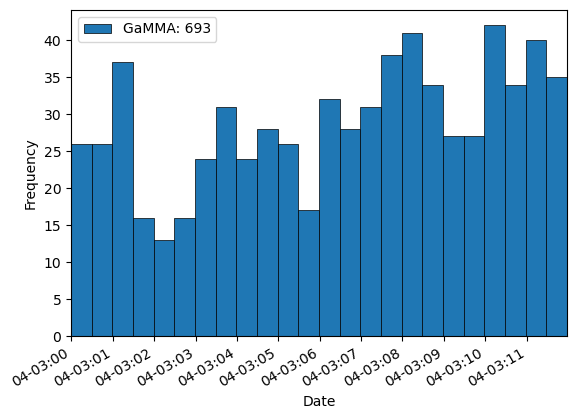

In [8]:
stations = pd.read_csv(data_path("stations.csv"))
gamma_events = pd.read_csv(result_path("gamma_events.csv"), parse_dates=["time"])

if os.path.exists(data_path("standard_catalog.csv")):
    standard_catalog = pd.read_csv(data_path("standard_catalog.csv"), parse_dates=["time"])
    starttime = standard_catalog["time"].min()
    endtime = standard_catalog["time"].max()
else:
    standard_catalog = None
    starttime = gamma_events["time"].min()
    endtime = gamma_events["time"].max()


plt.figure()
plt.hist(gamma_events["time"], range=(starttime, endtime), bins=24, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{result_label}: {len(gamma_events['time'])}")
if standard_catalog is not None:
    plt.hist(standard_catalog["time"], range=(starttime, endtime), bins=24, edgecolor="k", alpha=0.6, linewidth=0.5, label=f"{catalog_label}: {len(standard_catalog['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(figure_dir("earthquake_number.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_number.pdf"), bbox_inches="tight")
plt.show();

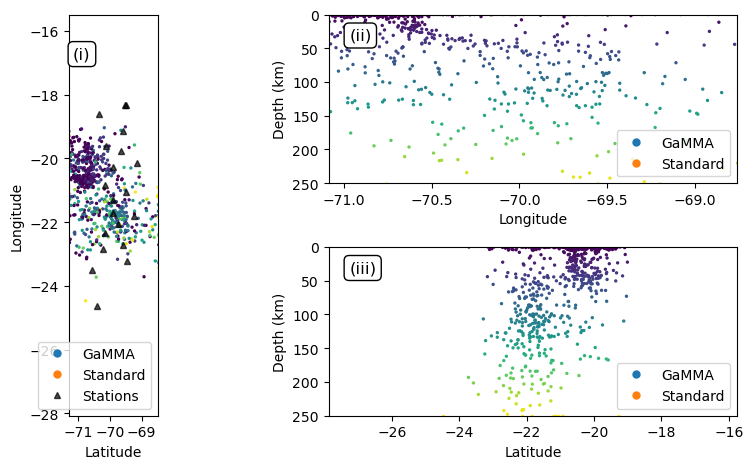

In [16]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.scatter(gamma_events["longitude"], gamma_events["latitude"], s=2, c=gamma_events["z(km)"])
if standard_catalog is not None:
    plt.plot(standard_catalog["longitude"], standard_catalog["latitude"], '.', markersize=5, alpha=0.6)
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))
plt.ylim(np.array(config["ylim_degree"]))
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}", rasterized=True)
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}", rasterized=True)
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=5, alpha=0.7, label="Stations")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.scatter(gamma_events["longitude"], gamma_events["depth_km"], c=gamma_events["z(km)"], s=2, alpha=1.0, rasterized=True)
if standard_catalog is not None:
    plt.scatter(gamma_events["longitude"], gamma_events["depth_km"], c=gamma_events["z(km)"], s=5, alpha=0.6, rasterized=True)
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim(config["z(km)"])
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}")
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.scatter(gamma_events["latitude"], gamma_events["depth_km"], c=gamma_events["z(km)"], s=2, alpha=1.0, rasterized=True)
if standard_catalog is not None:
    plt.scatter(gamma_events["latitude"], gamma_events["depth_km"], c=gamma_events["z(km)"], s=2, alpha=0.6, rasterized=True)
plt.xlim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.ylim(config["z(km)"])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}")
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig(figure_dir("earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show();

In [10]:
if standard_catalog is not None:
    range = (0, standard_catalog["magnitude"].max())
else:
    range = (-1, gamma_events["magnitude"].max())
if (gamma_events["magnitude"] != 999).any():
    plt.figure()
    plt.hist(gamma_events["magnitude"], range=range, bins=25, alpha=1.0,  edgecolor="k", linewidth=0.5, label=f"{result_label}: {len(gamma_events['magnitude'])}")
    if standard_catalog is not None:
        plt.hist(standard_catalog["magnitude"], range=range, bins=25, alpha=0.6,  edgecolor="k", linewidth=0.5, label=f"{catalog_label}: {len(standard_catalog['magnitude'])}")
    plt.legend()
    plt.xlabel("Magnitude")
    plt.ylabel("Frequency")
    plt.gca().set_yscale('log')
    plt.savefig(figure_dir("earthquake_magnitude_frequency.png"), bbox_inches="tight", dpi=300)
    plt.savefig(figure_dir("earthquake_magnitude_frequency.pdf"), bbox_inches="tight")
    plt.show();

In [11]:
if (gamma_events["magnitude"] != 999).any():
    plt.figure()
    plt.plot(gamma_events["time"], gamma_events["magnitude"], '.', markersize=5, alpha=1.0, rasterized=True)
    if standard_catalog is not None:
        plt.plot(standard_catalog["time"], standard_catalog["magnitude"], '.', markersize=5, alpha=0.8, rasterized=True)
        len_standard_catalog = len(standard_catalog['magnitude'])
    else:
        len_standard_catalog = 0
    
    plt.xlim([starttime, endtime])
    ylim = plt.ylim()
    plt.ylabel("Magnitude")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    plt.gcf().autofmt_xdate()
    plt.gca().set_prop_cycle(None)
    plt.plot([],[], '.', markersize=15, alpha=1.0, label=f"{result_label}: {len(gamma_events['magnitude'])}")
    plt.plot([],[], '.', markersize=15, alpha=1.0, label=f"{catalog_label}: {len_standard_catalog}")
    plt.legend()
    plt.ylim(ylim)
    plt.grid()
    plt.savefig(figure_dir("earthquake_magnitude_time.png"), bbox_inches="tight", dpi=300)
    plt.savefig(figure_dir("earthquake_magnitude_time.pdf"), bbox_inches="tight", dpi=300)
    plt.show()


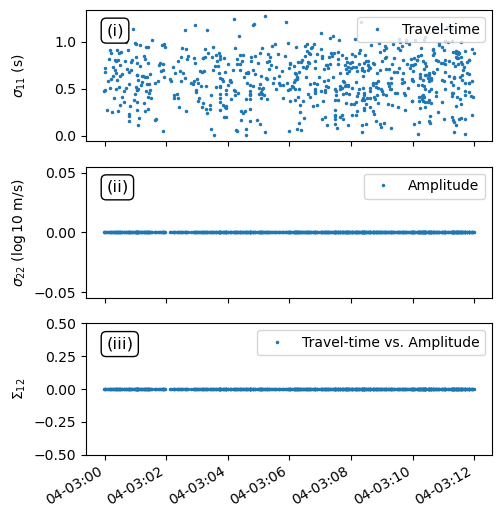

In [12]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([0.8,1.1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.90]
plt.subplot(311)
plt.plot(gamma_events["time"], gamma_events["sigma_time"], '.', markersize=3.0, label="Travel-time")
plt.ylabel(r"$\sigma_{11}$ (s)")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(312)
plt.plot(gamma_events["time"], gamma_events["sigma_amp"], '.', markersize=3.0, label="Amplitude")
plt.ylabel(r"$\sigma_{22}$ ($\log10$ m/s)")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(313)
plt.plot(gamma_events["time"], gamma_events["cov_time_amp"], '.', markersize=3.0, label="Travel-time vs. Amplitude")
plt.ylabel(r"$\Sigma_{12}$")
plt.ylim([-0.5, 0.5])
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.gcf().align_labels()
plt.savefig(figure_dir("covariance.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("covariance.pdf"), bbox_inches="tight")
plt.show();

Text(0, 0.5, 'Northing [km]')

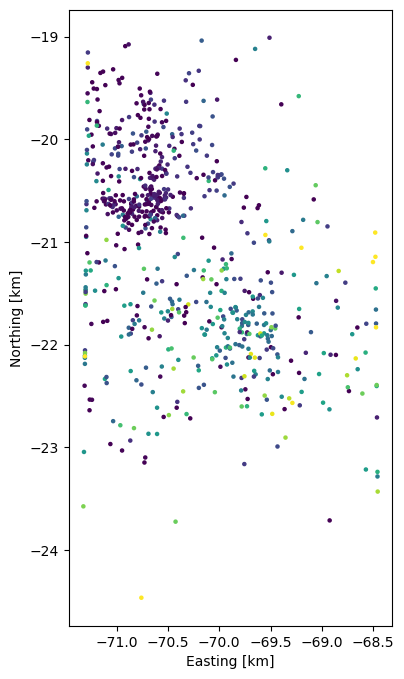

In [13]:
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

ax.scatter(gamma_events["longitude"], gamma_events["latitude"], s=5,c=gamma_events["z(km)"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")